# DSCI 417 – Homework 06
**Lauren Forti**

In [0]:
# setup
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.getOrCreate()

## Problem 1: Load Stroke Data

In [0]:
# read file into df
stroke_df = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('gender STRING, age DOUBLE, hyptertension INTEGER, heart_disease INTEGER, ever_married STRING, work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING, stroke INTEGER')
    .csv('/FileStore/tables/stroke_data.csv')
)

# display schema
stroke_df.printSchema()

root
-- gender: string (nullable = true)
-- age: double (nullable = true)
-- hyptertension: integer (nullable = true)
-- heart_disease: integer (nullable = true)
-- ever_married: string (nullable = true)
-- work_type: string (nullable = true)
-- residence_type: string (nullable = true)
-- avg_glucose_level: double (nullable = true)
-- bmi: double (nullable = true)
-- smoking_status: string (nullable = true)
-- stroke: integer (nullable = true)

In [0]:
# display first 10 rows of df
stroke_df.show(10)

+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
gender| age|hyptertension|heart_disease|ever_married| work_type|residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
Female|13.0| 0| 0| No| Private| Urban| 77.63|31.7| never smoked| 0|
 Male|10.0| 0| 0| No| Child| Rural| 84.02|18.7| never smoked| 0|
Female|82.0| 0| 1| Yes|Self-employed| Rural| 88.6|32.5| Unknown| 0|
Female| 3.0| 0| 0| No| Child| Urban| 57.33|16.8| Unknown| 0|
Female|65.0| 0| 0| Yes|Self-employed| Rural| 220.52|37.2| smokes| 0|
Female|65.0| 0| 0| Yes|Self-employed| Rural| 100.65|31.0| never smoked| 1|
 Male|65.0| 0| 0| Yes| Private| Rural| 56.64|28.4|formerly smoked| 1|
Female|28.0| 0| 0| Yes| Private| Rural| 64.64|22.1| never smoked| 0|
Female|80.0| 0| 0| Yes| Govt_job| Urban| 84.86|29.3| Unknown| 0|
 Male|78.0| 0| 0| Yes| Private| Urban| 60.22|29.7|formerly smoked| 0|
+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
only showing top 10 rows

In [0]:
# count # of observations
N = stroke_df.count()
print(N)

6853

In [0]:
# calc prop of records in label categories
(
  stroke_df
# group by stroke col
  .groupBy('stroke')
  .agg(
    expr(f'ROUND(COUNT(*)/{N},4) as prop')
  )
 ).show()

+------+------+
stroke| prop|
+------+------+
 1|0.2907|
 0|0.7093|
+------+------+

## Problem 2: Preprocessing

In [0]:
# lists to store names of cols for features
num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = [c for c in stroke_df.columns[:-1] if c not in num_features]

# lists to store int encoded cat cols
ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

# use cols in cat_features to create cols in ix_features
feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

# one-hot encoded cat features
encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)

# combine num features and one-hot encoded features
assembler = VectorAssembler(inputCols=num_features + vec_features, outputCol='features')

In [0]:
# create pipeline w/ previously created objs then fit to df
pre_pipe = Pipeline(stages=[feature_indexer, encoder, assembler]).fit(stroke_df)

# store processed df
train = pre_pipe.transform(stroke_df)

# persist the train df
train.persist()

# display df
train.select(['features', 'stroke']).show(10, truncate=False)

+----------------------------------------------------------------------------+------+
features |stroke|
+----------------------------------------------------------------------------+------+
(22,[0,1,2,3,5,7,10,11,16,18],[13.0,77.63,31.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0 |
(22,[0,1,2,4,5,7,10,14,17,18],[10.0,84.02,18.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0 |
(22,[0,1,2,3,5,8,9,12,17,19],[82.0,88.6,32.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
(22,[0,1,2,3,5,7,10,14,16,19],[3.0,57.33,16.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
(22,[0,1,2,3,5,7,9,12,17,21],[65.0,220.52,37.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0 |
(22,[0,1,2,3,5,7,9,12,17,18],[65.0,100.65,31.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|1 |
(22,[0,1,2,4,5,7,9,11,17,20],[65.0,56.64,28.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |1 |
(22,[0,1,2,3,5,7,9,11,17,18],[28.0,64.64,22.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
(22,[0,1,2,3,5,7,9,13,16,19],[80.0,84.86,29.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
(22,[0,1,2,4,5,7,9,11,16,20],[78.0,60.22,29.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |0 |
+----------------------------------------------------------------------------+------+
only showing top 10 rows

## Problem 3: Hyperparameter Tuning for Logistic Regression

In [0]:
# create accuracy evaluator for models
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='stroke', metricName='accuracy'
)

# create instance of logistic regression class
logreg = LogisticRegression(featuresCol='features', labelCol='stroke')

# create param grid
param_grid = (ParamGridBuilder()
              .addGrid(logreg.regParam, [0.0001, 0.001, 0.01, 0.1, 1])
              .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
             ).build()

# grid search
cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval, 
                    numFolds=5, seed=1)

# fit
cv_model = cv.fit(train)

In [0]:
model = cv_model.bestModel

# store parameter vals
opt_regParam = model.getRegParam()
opt_enetParam = model.getElasticNetParam()

# output results
print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Lambda:', opt_regParam)
print('Optimal Alpha: ', opt_enetParam)

Max CV Score: 0.774
Optimal Lambda: 0.01
Optimal Alpha: 0.0

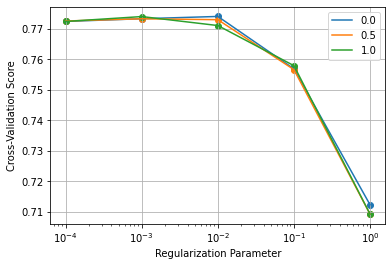

In [0]:
# plot results
model_params = cv_model.getEstimatorParamMaps()

lr_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
  new_set = list(param_set.values()) + [acc]
  lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list, 
                          columns=['reg_param', 'enet_param', 'acc'])

for en in cv_summary.enet_param.unique():
  sel = cv_summary.enet_param == en
  plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en)
  plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])

plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Cross-Validation Score')
plt.show()

## Problem 4: Training Predictions

In [0]:
# generate predictions for train set
train_pred = model.transform(train)
train_pred.select('probability', 'prediction', 'stroke').show(10, truncate=False)

+-----------------------------------------+----------+------+
probability |prediction|stroke|
+-----------------------------------------+----------+------+
[0.9747140890756103,0.0252859109243897] |0.0 |0 |
[0.9872318011645983,0.0127681988354017] |0.0 |0 |
[0.29265947121077845,0.7073405287892216] |1.0 |0 |
[0.9908447681537692,0.009155231846230794]|0.0 |0 |
[0.5429884231739687,0.45701157682603133] |0.0 |0 |
[0.7013317009925937,0.2986682990074063] |0.0 |1 |
[0.6793380107028687,0.3206619892971313] |0.0 |1 |
[0.9522140166448959,0.04778598335510409] |0.0 |0 |
[0.4894259348203679,0.5105740651796321] |1.0 |0 |
[0.4749500136675296,0.5250499863324705] |1.0 |0 |
+-----------------------------------------+----------+------+
only showing top 10 rows

In [0]:
# find rows where prediction different from stroke
(
  train_pred
  .filter((col('prediction') != col('stroke')))
  .select('probability', 'prediction', 'stroke')
).show(10, truncate=False)

+----------------------------------------+----------+------+
probability |prediction|stroke|
+----------------------------------------+----------+------+
[0.29265947121077845,0.7073405287892216]|1.0 |0 |
[0.7013317009925937,0.2986682990074063] |0.0 |1 |
[0.6793380107028687,0.3206619892971313] |0.0 |1 |
[0.4894259348203679,0.5105740651796321] |1.0 |0 |
[0.4749500136675296,0.5250499863324705] |1.0 |0 |
[0.3106588756065039,0.6893411243934962] |1.0 |0 |
[0.5111778916185864,0.4888221083814136] |0.0 |1 |
[0.5394169187722885,0.4605830812277115] |0.0 |1 |
[0.5501176180010955,0.4498823819989045] |0.0 |1 |
[0.6985579547487483,0.30144204525125173]|0.0 |1 |
+----------------------------------------+----------+------+
only showing top 10 rows

* The highest probability observed for an incorrect answer is .7073.
* The lowest probability observed for an incorrect answer is .2927.

## Problem 5: Classification Metrics

In [0]:
# create pair of RDD label pairs
pred_and_labels = train_pred.rdd.map(lambda x:(x['prediction'],float(x['stroke'])))

# create instance of metrics
metrics = MulticlassMetrics(pred_and_labels)

# output accuracy
print(metrics.accuracy)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
0.776010506347585

In [0]:
# get confusion matrix
cm = metrics.confusionMatrix().toArray().astype(int)

# display df
pd.DataFrame(
  data=cm
)

Out[14]:

,0,1
0,4323,538
1,997,995


In [0]:
# display precision and recall for both label values
print('Label   Precision   Recall')
print('-'*26)
for i, lab in enumerate([0,1]):
  print(f'{lab:<8}{metrics.precision(i):<12.4f}{metrics.recall(i):.4f}')

Label Precision Recall
--------------------------
0 0.8126 0.8893
1 0.6491 0.4995

## Problem 6: Applying the Model to New Data

In [0]:
# new data
data = [
  ['Female', 42.0, 1, 0, 'No', 'Private', 'Urban', 182.1, 26.8, 'smokes'],
  ['Female', 64.0, 1, 1, 'Yes', 'Self-employed', 'Rural', 171.5, 32.5, 'formerly smoked'],
  ['Male', 37.0, 0, 0, 'Yes', 'Private', 'Rural', 79.2, 18.4, 'Unknown'],
  ['Male', 72.0, 0, 1, 'No', 'Govt_job', 'Urban', 125.7, 19.4, 'never smoked']
]

# make new data into df
new_data = spark.createDataFrame(
  data, 
  schema = ('gender STRING, age DOUBLE, hyptertension INTEGER, heart_disease INTEGER, ever_married STRING, work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING')
)

# display new df
new_data.show()

+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
gender| age|hyptertension|heart_disease|ever_married| work_type|residence_type|avg_glucose_level| bmi| smoking_status|
+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
Female|42.0| 1| 0| No| Private| Urban| 182.1|26.8| smokes|
Female|64.0| 1| 1| Yes|Self-employed| Rural| 171.5|32.5|formerly smoked|
 Male|37.0| 0| 0| Yes| Private| Rural| 79.2|18.4| Unknown|
 Male|72.0| 0| 1| No| Govt_job| Urban| 125.7|19.4| never smoked|
+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+

In [0]:
# apply processing pipeine
new_data_pcd = pre_pipe.transform(new_data)

# apply model
new_data_pred = model.transform(new_data_pcd)

# display results
new_data_pred.select('probability', 'prediction').show(truncate=False)

+----------------------------------------+----------+
probability |prediction|
+----------------------------------------+----------+
[0.7054270074784814,0.2945729925215186] |0.0 |
[0.2757821232703251,0.724217876729675] |1.0 |
[0.9126460874571503,0.08735391254284974]|0.0 |
[0.40098498644373304,0.599015013556267] |1.0 |
+----------------------------------------+----------+